In [1]:
import torch
import sys
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.losses import SingleVisLoss, UmapLoss, ReconstructionLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
import singleVis.config as config
from singleVis.eval.evaluator import Evaluator
from singleVis.spatial_edge_constructor import kcSpatialEdgeConstructor
from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.trajectory import draw_trajectory, draw_two_trajectories

In [2]:
dataset = "pairflip"
DATASET = "cifar10"
CONTENT_PATH ="/home/xianglin/projects/DVI_data/noisy/{}/cifar10/".format(dataset)
DATASET = "cifar10_n"

In [10]:
dataset = "cifar10"
DATASET = "cifar10"
CONTENT_PATH ="/home/xianglin/projects/DVI_data/TemporalExp/resnet18_cifar10"


In [2]:
DATASET = "cifar10"
CONTENT_PATH ="/home/xianglin/projects/DVI_data/resnet18_cifar10"
DATASET = "cifar10_full"

In [3]:
LEN = config.dataset_config[DATASET]["TRAINING_LEN"]
LAMBDA = config.dataset_config[DATASET]["LAMBDA"]
L_BOUND = config.dataset_config[DATASET]["L_BOUND"]
MAX_HAUSDORFF = config.dataset_config[DATASET]["MAX_HAUSDORFF"]
ALPHA = config.dataset_config[DATASET]["ALPHA"]
BETA = config.dataset_config[DATASET]["BETA"]
INIT_NUM = config.dataset_config[DATASET]["INIT_NUM"]
EPOCH_START = config.dataset_config[DATASET]["EPOCH_START"]
EPOCH_END = config.dataset_config[DATASET]["EPOCH_END"]
EPOCH_PERIOD = config.dataset_config[DATASET]["EPOCH_PERIOD"]
HIDDEN_LAYER = config.dataset_config[DATASET]["HIDDEN_LAYER"]

# define hyperparameters
DEVICE = torch.device("cuda:{:d}".format(0) if torch.cuda.is_available() else "cpu")
S_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["S_N_EPOCHS"]
B_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["B_N_EPOCHS"]
T_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["T_N_EPOCHS"]
N_NEIGHBORS = config.dataset_config[DATASET]["training_config"]["N_NEIGHBORS"]
PATIENT = config.dataset_config[DATASET]["training_config"]["PATIENT"]
MAX_EPOCH = config.dataset_config[DATASET]["training_config"]["MAX_EPOCH"]
CLASSES = list(range(10))

content_path = CONTENT_PATH
sys.path.append(content_path)

from Model.model import *
net = resnet18()
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [4]:
data_provider = NormalDataProvider(content_path, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=classes, verbose=1)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=HIDDEN_LAYER)
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
edge_loader = None
trainer = SingleVisTrainer(model, criterion, optimizer, lr_scheduler,edge_loader=edge_loader, DEVICE=DEVICE)
trainer.load(file_path=os.path.join(data_provider.model_path, "tnn.pth"))
trainer.model.to(DEVICE)
trainer.model.eval()

Finish initialization...
Successfully load visualization model...


SingleVisualizationModel(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=256, 

Computing decision regions ...


100%|██████████| 800/800 [00:00<00:00, 4459.94it/s]


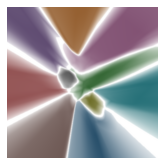

In [14]:
from singleVis.visualizer import visualizer

vis = visualizer(data_provider, trainer.model, 200, 10, CLASSES)
vis.get_background(2, 400)

In [5]:
samples = np.zeros((161, 50000, 512))
for i in range(0, 161, 1):
    samples[i] = data_provider.train_representation(i+40)

In [7]:
import json
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/clean_label.json".format(dataset)
with open(path, "r") as f:
    clean_label = json.load(f)
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/noisy_label.json".format(dataset)
with open(path, "r") as f:
    noisy_label = json.load(f)

In [6]:
train_labels = data_provider.train_labels(40)

In [7]:
embeddings_2d = np.zeros((50000, 161, 2))
for i in range(50000):
    embedding_2d = trainer.model.encoder(torch.from_numpy(samples[:,i,:]).to(device=DEVICE, dtype=torch.float)).cpu().detach().numpy()
    embeddings_2d[i] = embedding_2d

In [7]:
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/embedding.npy".format(dataset)
np.save(path, embeddings_2d)

In [8]:
path = os.path.join(CONTENT_PATH, "embedding.npy")
np.save(path, embeddings_2d)

In [9]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.manifold import TSNE 
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import Birch, KMeans

In [9]:
def select_centroid(samples, n_select=3):
    kmeans = KMeans(n_clusters=n_select).fit(samples)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(samples)
    indices = nbrs.kneighbors(kmeans.cluster_centers_,return_distance=False)
    return indices.squeeze()

In [10]:
def test_abnormal(directions, repeat=2, show=True, dr="umap"):
    for _ in range(repeat):
        if dr=="umap":
            reducer = umap.UMAP(n_components=2)
            embedding = reducer.fit_transform(directions)
        elif dr=="tsne":
            embedding = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(high_data)
        else:
            print("illgal dr algorithm!")
            return False

        brc = Birch(n_clusters=2)
        brc.fit(embedding)

        s = silhouette_score(embedding, brc.labels_, metric='euclidean')
        c = calinski_harabasz_score(embedding, brc.labels_)
        if s <= 0.1:
            continue
        else:
            break
    if s <= 0.1:
        print("No abnormal trajectories detected!")
        return False
    print("silhouette_score\t", s)
    print("calinski_harabasz_score\t", c)

    labels = brc.labels_
    centroid = brc.subcluster_centers_
    centroid_labels = brc.subcluster_labels_
    # clean 1, noise 0
    bin = np.bincount(centroid_labels)
    if bin[0] > bin[1]:
        centroid_labels = np.abs(centroid_labels-1)
        labels = np.abs(labels-1)
    
    # select 3 representative clean ones
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(embedding)
    indices = nbrs.kneighbors(centroid, return_distance=False)
    centroid = embedding[indices.squeeze()]

    # calculate noise score
    clean_centroids = centroid[centroid_labels==1]
    clean_ones = embedding[labels==1]
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(clean_centroids)
    dists, _ = nbrs.kneighbors(clean_ones)
    norm_term = dists.max()

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(clean_centroids)
    dists, _ = nbrs.kneighbors(embedding)
    scores = dists/norm_term
    
    if show:
        plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=1,
            c=labels,
            cmap="Pastel2")

        c_idxs = select_centroid(clean_centroids)
        plt.scatter(
            clean_centroids[c_idxs][:, 0],
            clean_centroids[c_idxs][:, 1],
            s=4,
            c="black",
            )
        plt.scatter(
            centroid[centroid_labels==0][:, 0],
            centroid[centroid_labels==0][:, 1],
            s=4,
            c="red",
            )
        plt.title('Trajectories Visualization', fontsize=24)
        plt.show()

    return labels, scores, centroid, centroid_labels, embedding

In [11]:
noisy_label = np.array(noisy_label)
clean_label = np.array(clean_label)

In [ ]:
# clean dataset
for cls_num in range(10):
    cls = np.argwhere(train_labels == cls_num).squeeze()
    # lbs = np.array(train_labels)[cls]
    high_data = directions[cls].reshape(len(cls), -1)
    test_abnormal(high_data)

In [ ]:
# clean dataset
for cls_num in range(10):
    cls = np.argwhere(train_labels == cls_num).squeeze()
    # lbs = np.array(train_labels)[cls]
    high_data = embeddings_2d[cls].reshape(len(cls), -1)
    _,_,_,_,embedding = test_abnormal(high_data)
    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=train_labels[cls],
        cmap="tab10")
    plt.show()

In [ ]:
# pairflip
for cls_num in range(10):
    cls = np.argwhere(np.array(noisy_label)==cls_num).squeeze()
    # lbs = np.array(clean_label)[cls]
    high_data = embeddings_2d[cls].reshape(len(cls), -1)
    _,_,_,_,embedding = test_abnormal(high_data)
    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=clean_label[cls],
        cmap="tab10")
    plt.show()

In [ ]:
# symmetric
for cls_num in range(10):
    cls = np.argwhere(np.array(noisy_label)==cls_num).squeeze()
    # lbs = np.array(clean_label)[cls]
    high_data = embeddings_2d[cls].reshape(len(cls), -1)
    _,_,_,_,embedding = test_abnormal(high_data, dr="umap")
    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=clean_label[cls],
        cmap="tab10")
    plt.show()
    

# noise score

In [ ]:
cls_num = 1
cls = np.argwhere(np.array(noisy_label)==cls_num).squeeze()
high_data = directions[cls].reshape(len(cls), -1)

In [ ]:
cls_num = 1
cls = np.argwhere(train_labels == cls_num).squeeze()
high_data = directions[cls].reshape(len(cls), -1)

In [ ]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(high_data)

brc = Birch(n_clusters=2)
brc.fit(embedding)

s = silhouette_score(embedding, brc.labels_, metric='euclidean')
c = calinski_harabasz_score(embedding, brc.labels_)
print("silhouette_score\t", s)
print("calinski_harabasz_score\t", c)

labels = brc.labels_
centroid = brc.subcluster_centers_
centroid_labels = brc.subcluster_labels_

In [ ]:
bin = np.bincount(centroid_labels)
if bin[0]>bin[1]:
    centroid_labels = np.abs(centroid_labels-1)
# 0 is noise
bin = np.bincount(labels)
if bin[0]>bin[1]:
    labels = np.abs(labels-1)

In [ ]:
clean_ones = embedding[labels==1]
noise_ones = embedding[labels==0]

In [ ]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(centroid[centroid_labels==1])
dists, indices = nbrs.kneighbors(clean_ones)
norm = dists.max()
norm


In [ ]:
dists, indices = nbrs.kneighbors(noise_ones)
normed = dists/norm
normed.max(), normed.min(), normed.mean()

# ground truth

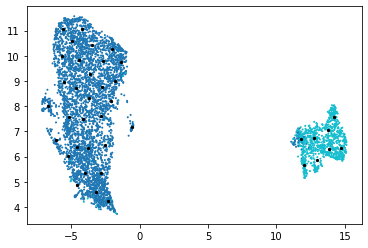

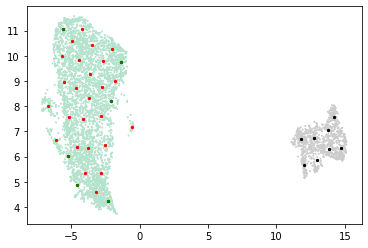

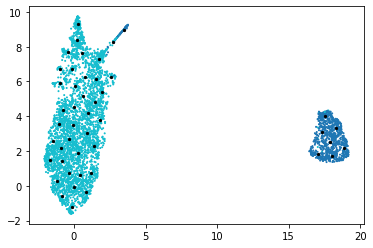

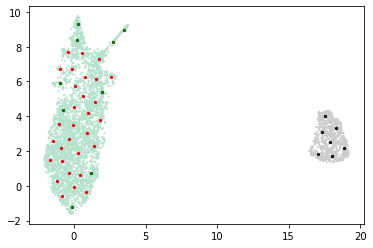

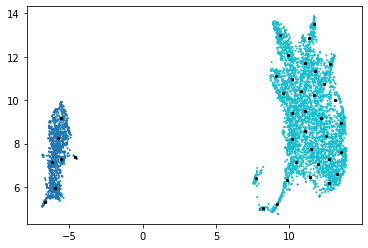

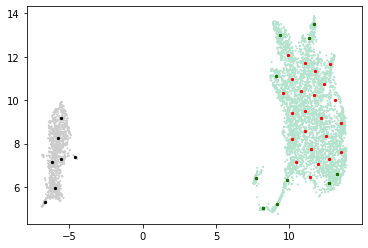

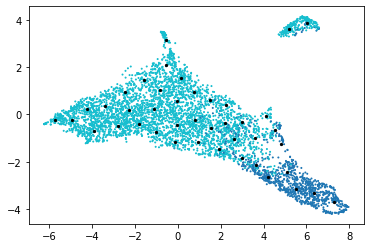

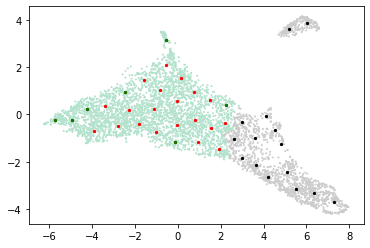

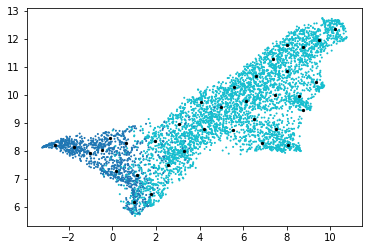

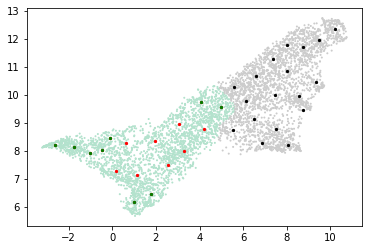

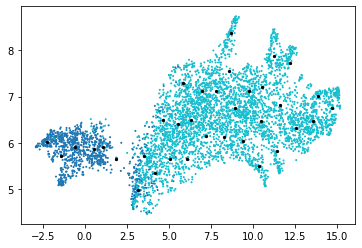

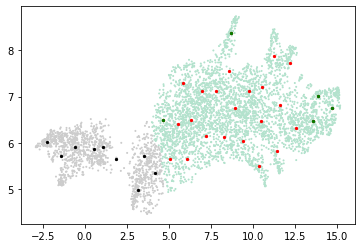

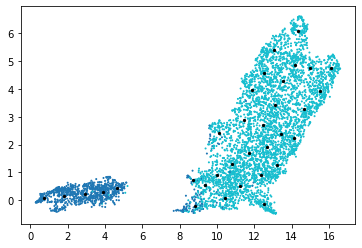

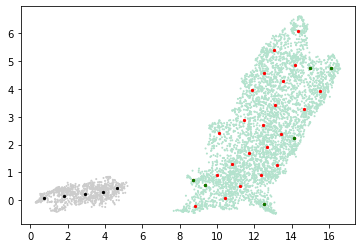

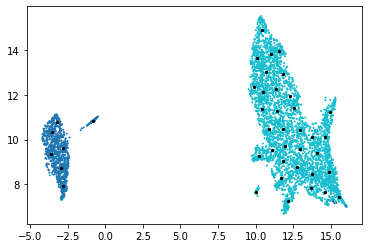

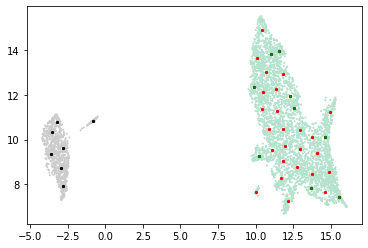

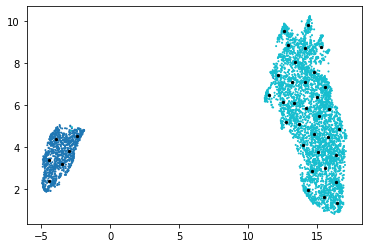

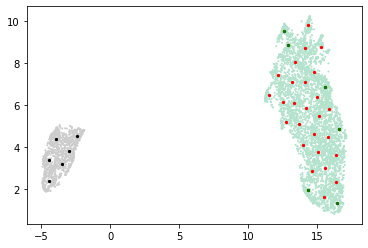

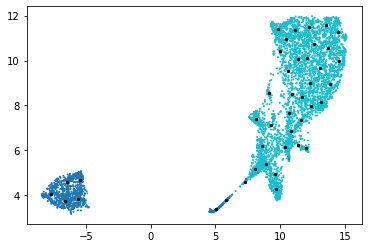

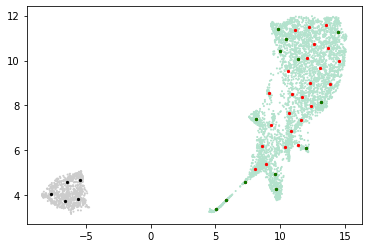

In [14]:
for cls_num in range(10):
    cls = np.argwhere(np.array(noisy_label)==cls_num).squeeze()
    high_data = embeddings_2d[cls].reshape(len(cls), -1)


    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(high_data)

    # from sklearn.manifold import TSNE
    # embedding = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(high_data)

    brc = Birch(n_clusters=2)
    brc.fit(embedding)

    labels = brc.labels_
    centroid = brc.subcluster_centers_
    centroid_labels = brc.subcluster_labels_
    # clean 1, noise 0
    bin = np.bincount(labels)
    if bin[0] > bin[1]:
        centroid_labels = np.abs(centroid_labels-1)
        labels = np.abs(labels-1)

    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=clean_label[cls],
        cmap="tab10")
    plt.scatter(
        brc.subcluster_centers_[:, 0],
        brc.subcluster_centers_[:, 1],
        s=5,
        c='black')
    plt.show()
    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=brc.labels_,
        cmap="Pastel2")

    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centroid[centroid_labels==1])
    dists, indices = nbrs.kneighbors(centroid[centroid_labels==1])
    suspicious = (dists[:, -1]/ dists[:, 1])>1.8

    cleans = centroid[centroid_labels==1]
    noises = centroid[centroid_labels==0]
    plt.scatter(
        cleans[:, 0],
        cleans[:, 1],
        s=5,
        c='r')
    plt.scatter(
        noises[:, 0],
        noises[:, 1],
        s=5,
        c='black')
    plt.scatter(
        cleans[suspicious][:, 0],
        cleans[suspicious][:, 1],
        s=5,
        c='g')
    plt.show()

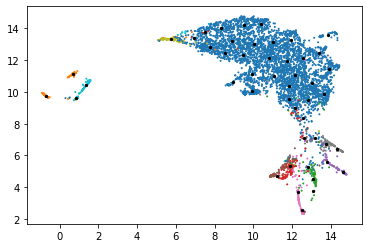

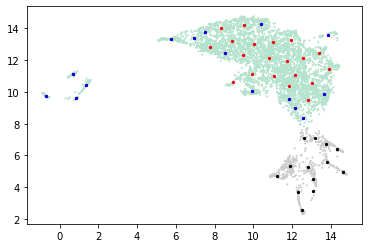

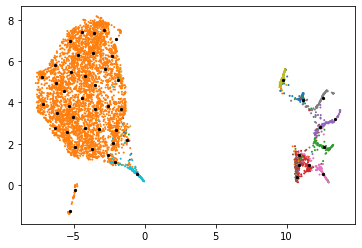

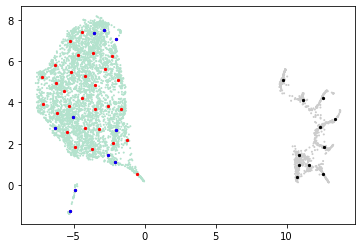

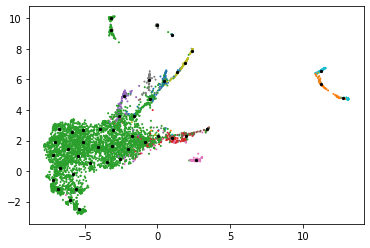

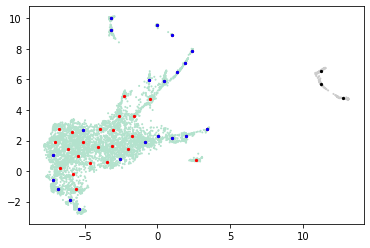

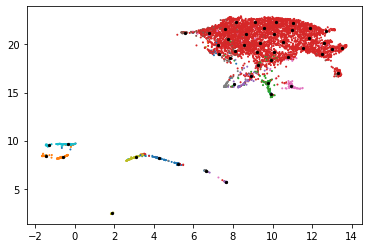

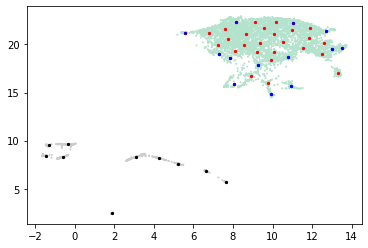

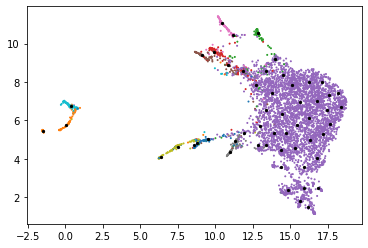

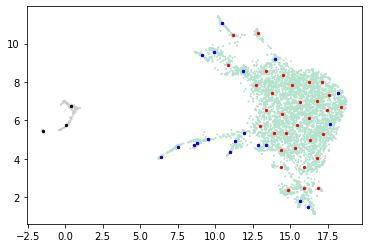

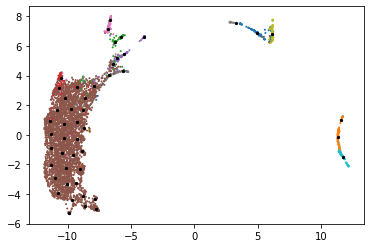

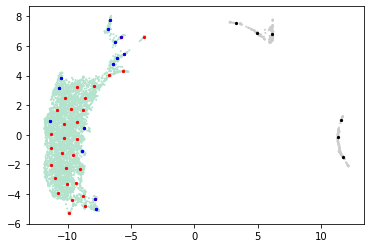

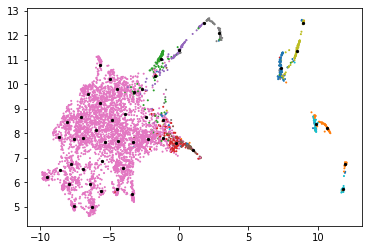

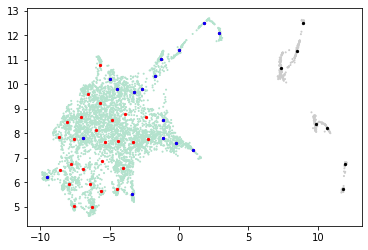

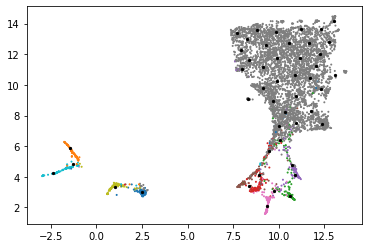

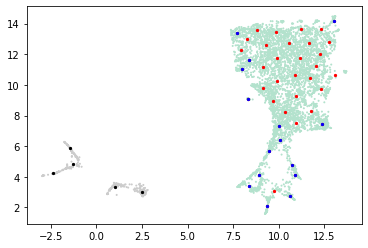

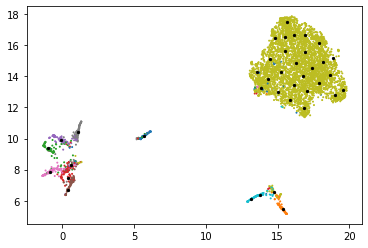

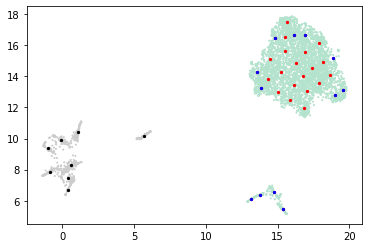

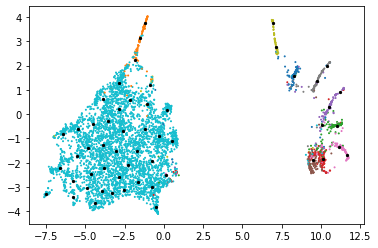

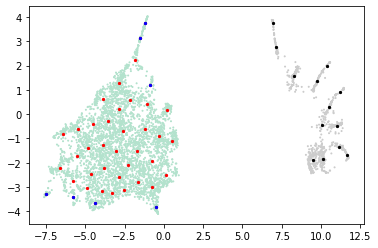

In [12]:
for cls_num in range(10):
    cls = np.argwhere(np.array(noisy_label)==cls_num).squeeze()
    high_data = embeddings_2d[cls].reshape(len(cls), -1)


    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(high_data)

    # from sklearn.manifold import TSNE
    # embedding = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(high_data)

    brc = Birch(n_clusters=2)
    brc.fit(embedding)

    labels = brc.labels_
    centroid = brc.subcluster_centers_
    centroid_labels = brc.subcluster_labels_
    # clean 1, noise 0
    bin = np.bincount(labels)
    if bin[0] > bin[1]:
        centroid_labels = np.abs(centroid_labels-1)
        labels = np.abs(labels-1)

    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=clean_label[cls],
        cmap="tab10")
    plt.scatter(
        brc.subcluster_centers_[:, 0],
        brc.subcluster_centers_[:, 1],
        s=5,
        c='black')
    plt.show()
    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=brc.labels_,
        cmap="Pastel2")

    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centroid[centroid_labels==1])
    dists, indices = nbrs.kneighbors(centroid[centroid_labels==1])
    suspicious = (dists[:, -1]/ dists[:, 1])>1.8

    cleans = centroid[centroid_labels==1]
    noises = centroid[centroid_labels==0]
    plt.scatter(
        cleans[:, 0],
        cleans[:, 1],
        s=5,
        c='r')
    plt.scatter(
        noises[:, 0],
        noises[:, 1],
        s=5,
        c='black')
    plt.scatter(
        cleans[suspicious][:, 0],
        cleans[suspicious][:, 1],
        s=5,
        c='b')
    plt.show()

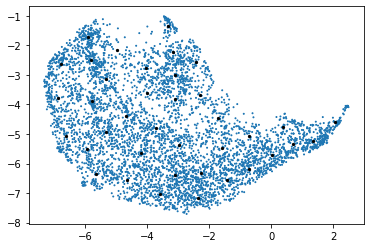

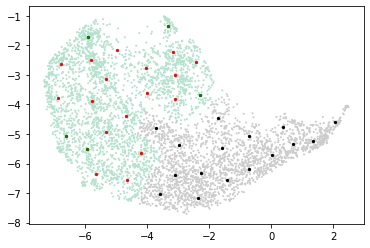

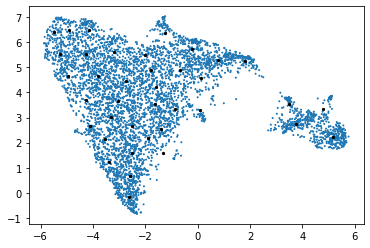

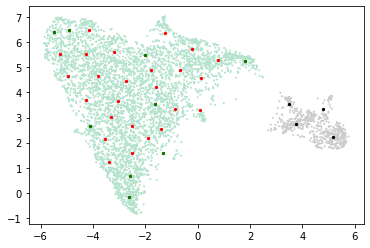

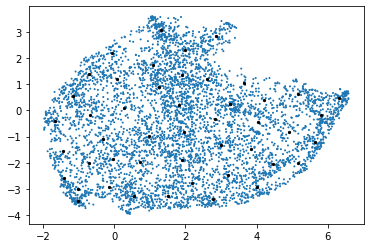

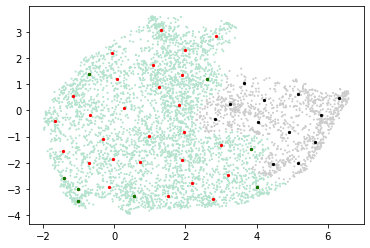

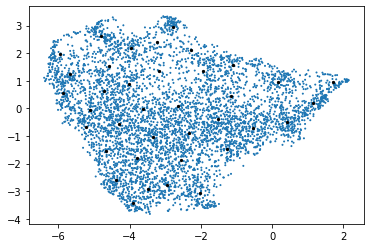

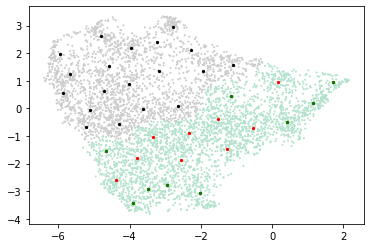

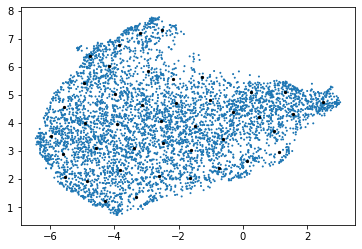

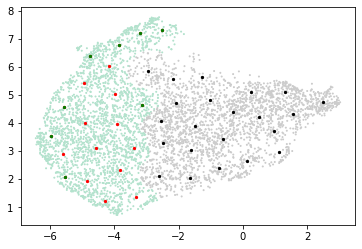

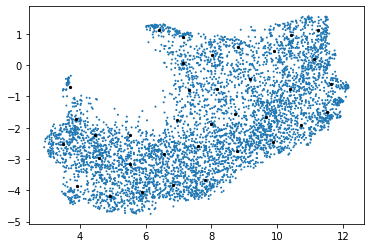

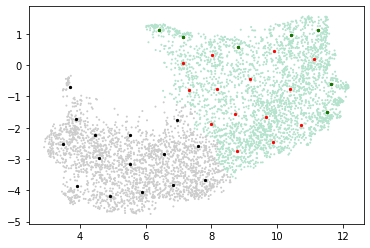

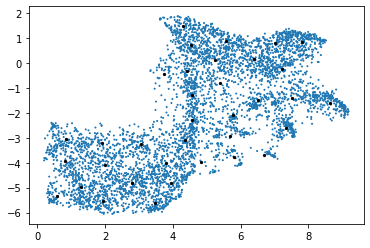

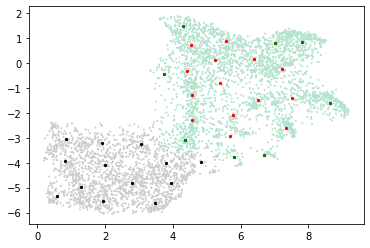

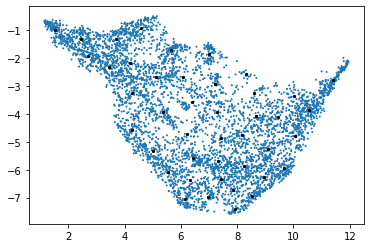

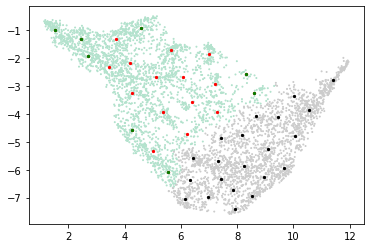

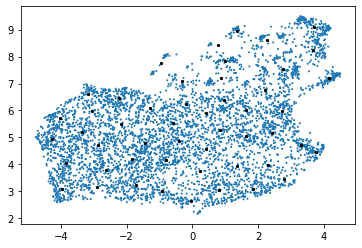

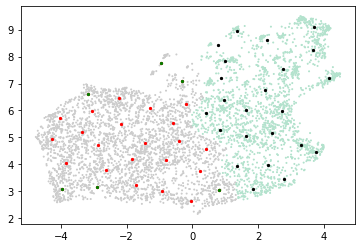

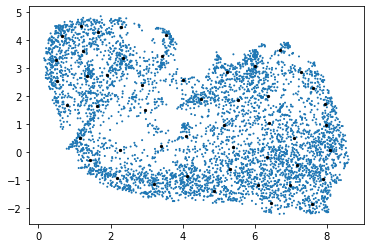

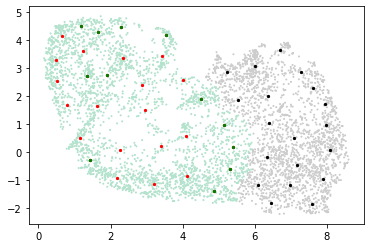

In [10]:
for cls_num in range(10):
    cls = np.argwhere(np.array(train_labels)==cls_num).squeeze()
    high_data = embeddings_2d[cls].reshape(len(cls), -1)


    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(high_data)

    # from sklearn.manifold import TSNE
    # embedding = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(high_data)

    brc = Birch(n_clusters=2)
    brc.fit(embedding)

    labels = brc.labels_
    centroid = brc.subcluster_centers_
    centroid_labels = brc.subcluster_labels_
    # clean 1, noise 0
    bin = np.bincount(labels)
    if bin[0] > bin[1]:
        centroid_labels = np.abs(centroid_labels-1)
        labels = np.abs(labels-1)

    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=train_labels[cls],
        cmap="tab10")
    plt.scatter(
        brc.subcluster_centers_[:, 0],
        brc.subcluster_centers_[:, 1],
        s=5,
        c='black')
    plt.show()
    plt.clf()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=brc.labels_,
        cmap="Pastel2")

    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centroid[centroid_labels==1])
    dists, indices = nbrs.kneighbors(centroid[centroid_labels==1])
    suspicious = (dists[:, -1]/ dists[:, 1])>1.8

    cleans = centroid[centroid_labels==1]
    noises = centroid[centroid_labels==0]
    plt.scatter(
        cleans[:, 0],
        cleans[:, 1],
        s=5,
        c='r')
    plt.scatter(
        noises[:, 0],
        noises[:, 1],
        s=5,
        c='black')
    plt.scatter(
        cleans[suspicious][:, 0],
        cleans[suspicious][:, 1],
        s=5,
        c='g')
    plt.show()

In [1]:
plt.clf()
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=1,
    c=brc.labels_,
    cmap="Pastel2")

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centroid[centroid_labels==1])
dists, indices = nbrs.kneighbors(centroid[centroid_labels==1])
suspicious = (dists[:, -1]/ dists[:, 1])>1.8

cleans = centroid[centroid_labels==1]
noises = centroid[centroid_labels==0]
plt.scatter(
    cleans[:, 0],
    cleans[:, 1],
    s=5,
    c='r')
plt.scatter(
    noises[:, 0],
    noises[:, 1],
    s=5,
    c='black')
plt.scatter(
    cleans[suspicious][:, 0],
    cleans[suspicious][:, 1],
    s=5,
    c='b')
plt.show()

NameError: name 'plt' is not defined